<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [1]:
!pip install pysynphot --quiet
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install git+https://github.com/astrofrog/sedfitter@master --quiet

     |████████████████████████████████| 10.8 MB 8.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


#**Imports**

In [2]:
import pysynphot as S

/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
!export PYSYN_CDBS=/my/local/dir/trds/

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from astropy.table import Table
from astropy.io import fits

import os
from time import perf_counter
import json
import requests
import pysynphot as S
import sedfitter as sed

import mastcasjobs

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

matplotlib.rcParams['font.size']=15
matplotlib.rcParams['figure.figsize']=(15,10)
sb.set_style('darkgrid')

In [5]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 392, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 392 (delta 7), reused 0 (delta 0), pack-reused 375
Receiving objects: 100% (392/392), 47.57 MiB | 24.48 MiB/s, done.
Resolving deltas: 100% (195/195), done.


In [6]:
cd INSIST/data

/content/INSIST/data


# **CasJobs**

## **Script**

In [7]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [8]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None ,cols = None):   

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
          self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                            from fGetNearbyObjEq({self.ra}, {self.dec}, 10) f
                            join ObjectThin o on o.objid=f.objid
                            join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                            join StackObjectThin mag on mag.objid=psc.objid
                            WHERE
                            mag.gPSFMag>-900 and 
                            mag.rPSFMag>-900 and 
                            mag.iPSFMag>-900 and 
                            mag.zPSFMag>-900 and 
                            mag.yPSFMag>-900 
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else:
          self.df = df 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **Query**

In [25]:
try:
  df = casjobs('M 67', cols = {'raStack':'ra','decStack':'dec'}).df
except:
  df = pd.read_csv('M67_PS1.csv')
  df =  df.rename(columns = {'raStack':'ra','decStack':'dec'})

In [26]:
df_star = df[df['ps_score']>0.5].copy()

In [27]:
df_star

,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score
2,121971328494717854,132.849460,11.647811,14.869100,0.000533,14.360300,0.000274,14.238800,0.000320,14.228000,0.000519,14.180500,0.000877,0.997500
3,121981327802535449,132.780255,11.654201,22.408501,0.070046,21.075701,0.020825,19.894899,0.010747,19.387800,0.012878,19.222099,0.028750,0.967161
7,121981328054472261,132.805456,11.651512,20.532900,0.016547,20.011999,0.012918,19.655001,0.009876,19.598499,0.015401,19.531300,0.032895,0.973104
8,121981328218108430,132.821806,11.656615,21.308001,0.035670,20.095501,0.021422,18.960800,0.006396,18.470501,0.006572,18.143700,0.010728,0.987833
10,121981328277113751,132.827729,11.652668,21.941999,0.059630,20.682800,0.015879,19.333900,0.007499,18.809700,0.007518,18.456301,0.013550,0.969271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,122361328754558683,132.875457,11.973499,14.265200,0.000371,13.934200,0.000273,13.864500,0.000378,13.834500,0.000453,13.799800,0.000760,0.998333
1826,122361328754558683,132.875457,11.973499,14.207000,0.000346,13.959600,0.000281,13.872400,0.000384,13.830000,0.000452,13.809400,0.000760,0.998333
1827,122361328818090634,132.881819,11.966787,16.971201,0.001754,16.576300,0.001196,16.217600,0.002029,16.417000,0.002133,16.384300,0.003584,0.997500
1828,122371328134963003,132.813494,11.977090,14.216200,0.000410,13.841900,0.000236,13.694600,0.000315,13.673500,0.000408,13.638000,0.000744,0.994167


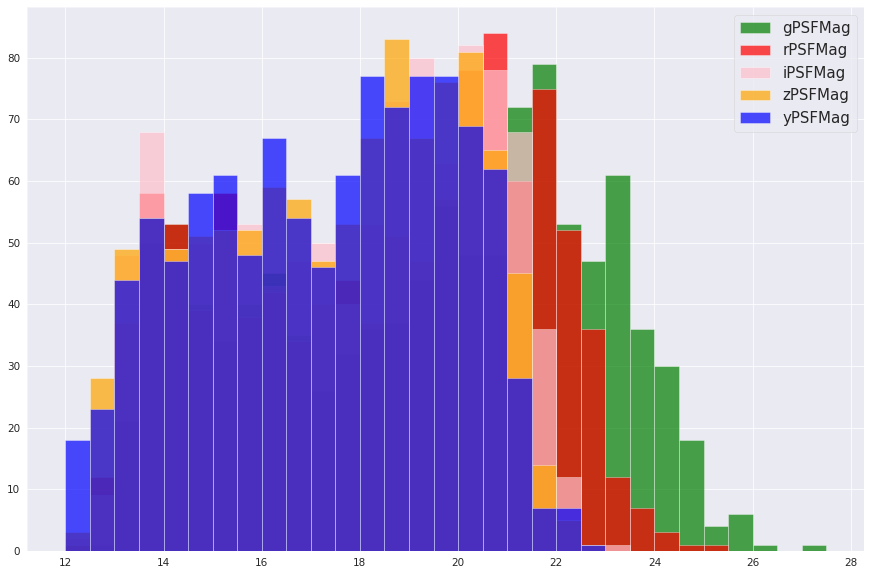

In [28]:
bin_min = 12
bin_max = 28
step  = 0.5
bins = np.arange(bin_min,bin_max, step)

plt.hist(df_star['gPSFMag'],bins=bins,alpha=0.7,color = 'green')
plt.hist(df_star['rPSFMag'],bins=bins,alpha=0.7,color = 'red')
plt.hist(df_star['iPSFMag'],bins=bins,alpha=0.7,color = 'pink')
plt.hist(df_star['zPSFMag'],bins=bins,alpha=0.7,color = 'orange')
plt.hist(df_star['yPSFMag'],bins=bins,alpha=0.7,color = 'blue');
plt.legend(['gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag',])

# **Synthetic Spectra**

## **Formatting the data**

In [125]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000*u.mJy
  df_star[f'{i}PSFFlux_err'] = 1.09*df_star[f'{i}PSFMagErr']/df_star[f'{i}PSFMag']*1000*u.mJy

In [126]:
df_star['g_flag'] = 1
df_star['i_flag'] = 1
df_star['r_flag'] = 1
df_star['z_flag'] = 1
df_star['y_flag'] = 1

In [127]:
df_star

,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,g_flag,i_flag,r_flag,z_flag,y_flag
2,121971328494717854,132.849460,11.647811,14.869100,0.000533,14.360300,0.000274,14.238800,0.000320,14.228000,0.000519,14.180500,0.000877,0.997500,4.096250,0.039072,6.544948,0.020798,7.319918,0.024496,7.393096,0.039760,7.723715,0.067412,1,1,1,1,1
3,121981327802535449,132.780255,11.654201,22.408501,0.070046,21.075701,0.020825,19.894899,0.010747,19.387800,0.012878,19.222099,0.028750,0.967161,0.003950,3.407195,0.013482,1.077034,0.040001,0.588806,0.063813,0.724013,0.074334,1.630285,1,1,1,1,1
7,121981328054472261,132.805456,11.651512,20.532900,0.016547,20.011999,0.012918,19.655001,0.009876,19.598499,0.015401,19.531300,0.032895,0.973104,0.022226,0.878406,0.035911,0.703609,0.049891,0.547690,0.052557,0.856550,0.055912,1.835799,1,1,1,1,1
8,121981328218108430,132.821806,11.656615,21.308001,0.035670,20.095501,0.021422,18.960800,0.006396,18.470501,0.006572,18.143700,0.010728,0.987833,0.010885,1.824681,0.033253,1.161951,0.094560,0.367687,0.148534,0.387834,0.200700,0.644495,1,1,1,1,1
10,121981328277113751,132.827729,11.652668,21.941999,0.059630,20.682800,0.015879,19.333900,0.007499,18.809700,0.007518,18.456301,0.013550,0.969271,0.006071,2.962205,0.019360,0.836836,0.067060,0.422776,0.108679,0.435659,0.150489,0.800242,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,122361328754558683,132.875457,11.973499,14.265200,0.000371,13.934200,0.000273,13.864500,0.000378,13.834500,0.000453,13.799800,0.000760,0.998333,7.144081,0.028348,9.690499,0.021355,10.332995,0.029718,10.622485,0.035691,10.967466,0.060030,1,1,1,1,1
1826,122361328754558683,132.875457,11.973499,14.207000,0.000346,13.959600,0.000281,13.872400,0.000384,13.830000,0.000452,13.809400,0.000760,0.998333,7.537483,0.026546,9.466427,0.021941,10.258081,0.030172,10.666607,0.035624,10.870923,0.059988,1,1,1,1,1
1827,122361328818090634,132.881819,11.966787,16.971201,0.001754,16.576300,0.001196,16.217600,0.002029,16.417000,0.002133,16.384300,0.003584,0.997500,0.590943,0.112653,0.850171,0.078645,1.183004,0.136371,0.984524,0.141620,1.014626,0.238433,1,1,1,1,1
1828,122371328134963003,132.813494,11.977090,14.216200,0.000410,13.841900,0.000236,13.694600,0.000315,13.673500,0.000408,13.638000,0.000744,0.994167,7.473883,0.031436,10.550336,0.018584,12.083318,0.025072,12.320440,0.032524,12.729942,0.059463,1,1,1,1,1


In [128]:
df_out = df_star[['objid', 'ra', 'dec', 'g_flag', 'i_flag', 'r_flag', 'z_flag','y_flag','gPSFFlux','gPSFFlux_err','rPSFFlux', 'rPSFFlux_err','iPSFFlux', 'iPSFFlux_err','zPSFFlux', 'zPSFFlux_err','yPSFFlux', 'yPSFFlux_err']]

In [307]:
df_out = df_out.drop_duplicates('objid')
df_out

,objid,ra,dec,g_flag,i_flag,r_flag,z_flag,y_flag,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,NUV_Flux,NUV_Flux_err,FUV_Flux
2,121971328494717854,132.849460,11.647811,1,1,1,1,1,4.096250,0.039072,6.544948,0.020798,7.319918,0.024496,7.393096,0.039760,7.723715,0.067412,1.638341e-02,2.497335e-05,2.262611e-08
3,121981327802535449,132.780255,11.654201,1,1,1,1,1,0.003950,3.407195,0.013482,1.077034,0.040001,0.588806,0.063813,0.724013,0.074334,1.630285,3.969901e-07,7.130470e-10,3.280446e-16
7,121981328054472261,132.805456,11.651512,1,1,1,1,1,0.022226,0.878406,0.035911,0.703609,0.049891,0.547690,0.052557,0.856550,0.055912,1.835799,4.027126e-07,7.164750e-10,5.658776e-17
8,121981328218108430,132.821806,11.656615,1,1,1,1,1,0.010885,1.824681,0.033253,1.161951,0.094560,0.367687,0.148534,0.387834,0.200700,0.644495,3.969901e-07,7.130470e-10,3.280446e-16
10,121981328277113751,132.827729,11.652668,1,1,1,1,1,0.006071,2.962205,0.019360,0.836836,0.067060,0.422776,0.108679,0.435659,0.150489,0.800242,5.481882e-07,9.766041e-10,5.838719e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,122361328325264775,132.832527,11.970217,1,1,1,1,1,0.073321,0.345806,0.245848,0.112324,0.745531,0.093947,1.376151,0.111014,1.711221,0.183656,1.834332e+03,1.842756e+00,4.021144e+00
1824,122361328646006536,132.864632,11.971754,1,1,1,1,1,0.000515,22.920168,0.002074,5.486179,0.007483,2.872162,0.013820,3.146784,0.021022,5.831993,5.481882e-07,9.766041e-10,5.838719e-16
1825,122361328754558683,132.875457,11.973499,1,1,1,1,1,7.144081,0.028348,9.690499,0.021355,10.332995,0.029718,10.622485,0.035691,10.967466,0.060030,4.739111e-02,6.171187e-05,3.423206e-07
1827,122361328818090634,132.881819,11.966787,1,1,1,1,1,0.590943,0.112653,0.850171,0.078645,1.183004,0.136371,0.984524,0.141620,1.014626,0.238433,5.123204e-01,5.932466e-04,1.204226e-05


In [130]:
df_out.reset_index().to_csv('data_input.dat', sep = " ",index=False, header=False)

## **Model**

In [35]:
if os.path.exists('models_kurucz'):
  os.system('rm -r models_kurucz')

In [36]:
!curl -o models ftp://ftp.astro.wisc.edu/outgoing/tom/model_packages/models_kurucz_05sep11.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83.0M  100 83.0M    0     0  5738k      0  0:00:14  0:00:14 --:--:-- 13.3M


In [37]:
!tar -xzf models

In [38]:
!rm models

## **Filters**

Initializing filter parameters using response curves

In [39]:
filter_dict = {'PS1g': [4881.47, 'PAN-STARRS_PS1.g.dat' ],
               'PS1r': [6198.41, 'PAN-STARRS_PS1.r.dat' ],
               'PS1i': [7549.34, 'PAN-STARRS_PS1.i.dat' ],
               'PS1z': [8701.37, 'PAN-STARRS_PS1.z.dat' ],
               'PS1y': [9509.80 ,'PAN-STARRS_PS1.y.dat' ],
               'UVIT_NUV': [2418.46,'Astrosat_UVIT.N242W.dat'],
               'UVIT_FUV': [1507.95,'Astrosat_UVIT.F148W.dat']}

model_dir = 'models_kurucz'

filter_list = []
for filter in filter_dict.keys():

  filt_obj = sed.filter.Filter()
  filt_obj.name = filter
  filt_obj.central_wavelength = (filter_dict[filter][0] * u.angstrom).to(u.micron)
  filt_obj_wl, filt_obj_rsr = np.loadtxt(filter_dict[filter][1], usecols=(0, 1), unpack=True)
  filt_obj.nu = 3.0e18 * u.Hz / np.flip(filt_obj_wl)
  filt_obj.response = filt_obj_rsr/filt_obj_rsr.max() 
  filt_obj.normalize()
  filter_list.append(filt_obj)

Convolving filters with models

In [40]:
sed.convolve.convolve_model_dir(model_dir, filter_list)

INFO: 3808 SEDs found in models_kurucz [sedfitter.convolve.convolve]
INFO: Rebinning filters [sedfitter.convolve.convolve]


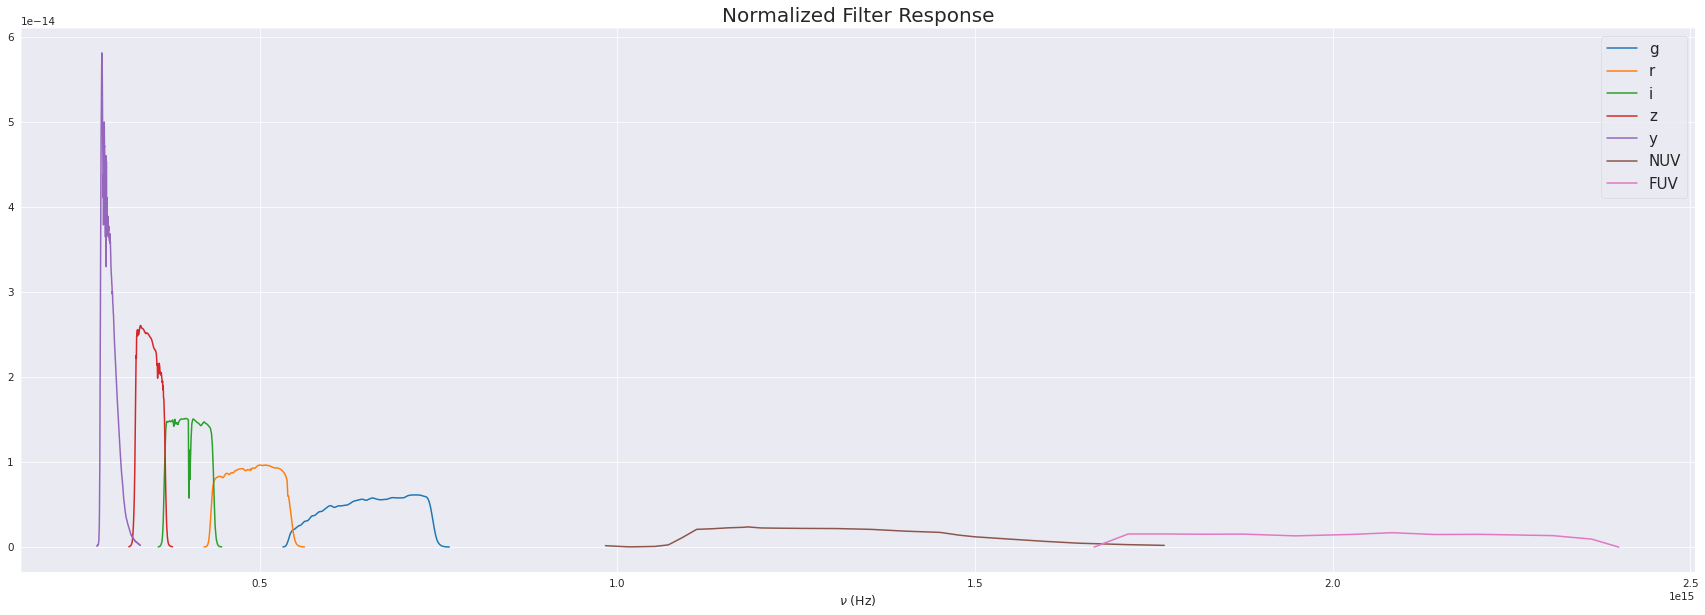

In [182]:
plt.figure(figsize = (30,10))
for filter in filter_list:
  plt.plot(filter.nu,filter.response)

plt.xlabel(r'$\nu$ (Hz)')
plt.title('Normalized Filter Response',size=20)
plt.legend(['g','r','i','z','y' ,'NUV','FUV'])

# **SED Fitting**

## **SED Fitter**

In [131]:
model_dir = 'models_kurucz'

# Read in extinction law)
extinction = sed.Extinction.from_file('kmh94.par', columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y']
apertures = [3., 3., 3., 3., 3.] * u.arcsec

# Run the fitting
d= sed.fit('data_input.dat', filters, apertures, model_dir, 'output.fitinfo', extinction_law=extinction, distance_range=[0.01, 2.] * u.Mpc,av_range=[0., 40.],output_convolved=True)

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  Kurucz stellar photospheres
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading models_kurucz/convolved/PS1g.fits
   Reading models_kurucz/convolved/PS1r.fits
   Reading models_kurucz/convolved/PS1i.fits
   Reading models_kurucz/convolved/PS1z.fits
   Reading models_kurucz/convolved/PS1y.fits
 ------------------------------------------------------------
  => Fitting parameters
 ------------------------------------------------------------

   Minimum A_V      :     0.000 mag
   Maximum A_V      :    40.000 mag
   Minimum distance :     0.010 Mpc
   Maximum distance :     2.000 Mpc

 ------------------------------------------------------------
  => Output parameters
 ----

Extracting fitting parameters from SED Fitter output

In [298]:
fin = sed.FitInfoFile('output.fitinfo', 'r')
modpar = sed.utils.parfile.read("%s/models.conf" % fin.meta.model_dir, 'conf')
nuv_filter = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1)
fuv_filter = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1)

UV = []
chi2 = []
for info in fin:
  model_name = info.model_name[0]
  chi2.append(info.chi2[0])
  NUV = [nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  FUV = [fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  UV.append(NUV + FUV)

Text(0.5, 1.0, 'SED Fitter')

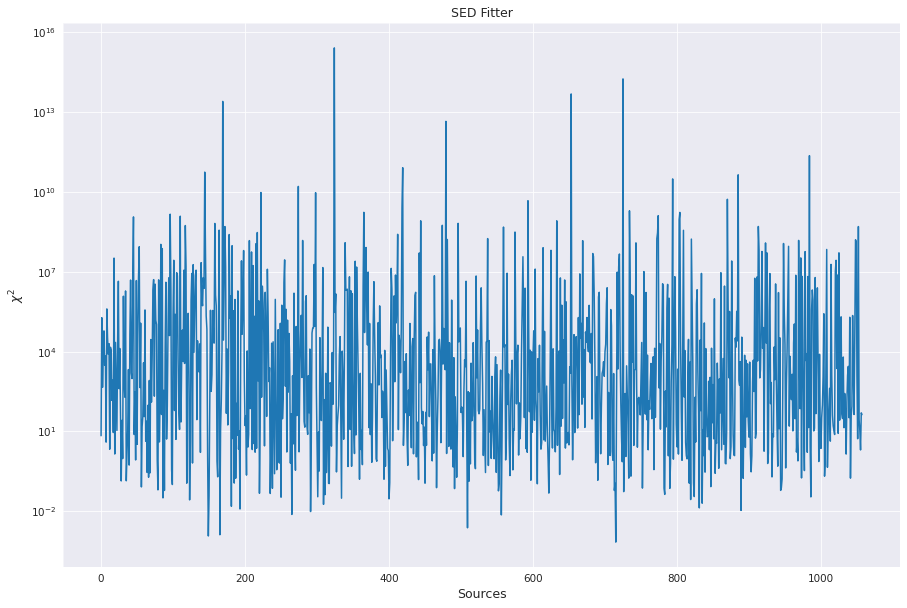

In [300]:
plt.plot(chi2)
plt.yscale('log')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.title('SED Fitter')

In [133]:
df_UV = pd.DataFrame(UV, columns = ['NUV_Flux','NUV_Flux_err','FUV_Flux','FUV_Flux_err'])

In [134]:
df_out['NUV_Flux']     = df_UV['NUV_Flux'].values
df_out['NUV_Flux_err'] = df_UV['NUV_Flux_err'].values
df_out['FUV_Flux']     = df_UV['FUV_Flux'].values
df_out['FUV_Flux']     = df_UV['FUV_Flux_err'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [304]:
df_out['objid'].unique().shape

(1046,)

# **SED Fitting Routine**

In [277]:
# Convolved Filters
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]

chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_out.iterrows():
  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux', 'yPSFFlux']].values
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for Md in np.linspace(1e-2,1e-10,5):
    for j,model_flux in enumerate(zip(f1,f2,f3,f4,f5)):
      model_flux = np.array(model_flux)
      chi = (flux - Md*model_flux)/flux_err
      chi2 = chi@chi
      chi_set.append([row['objid'],model_name[j],Md,chi2])

In [278]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','chi2'])

In [279]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [280]:
df_chi_min

,objid,model_name,Md,chi2
3802,1.219713e+17,kt50000g+5.0z+0.5,0.00001,246778.763349
22842,1.219813e+17,kt50000g+5.0z+0.5,0.00001,0.013136
41882,1.219813e+17,kt50000g+5.0z+0.5,0.00001,0.013937
60922,1.219813e+17,kt50000g+5.0z+0.5,0.00001,0.299721
79962,1.219813e+17,kt50000g+5.0z+0.5,0.00001,0.117306
...,...,...,...,...
20014842,1.223613e+17,kt50000g+5.0z+0.5,0.00001,306.916490
20033882,1.223613e+17,kt50000g+5.0z+0.5,0.00001,0.000027
20071962,1.223613e+17,kt50000g+5.0z+0.5,0.00001,504466.571030
20091002,1.223613e+17,kt50000g+5.0z+0.5,0.00001,283.940211


In [281]:
nuv_filter = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1)
fuv_filter = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1)
UV = []
for model_name in df_chi_min['model_name']:
  NUV = [nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  FUV = [fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  UV.append(NUV + FUV)
UV = np.array(UV)

In [282]:
df_chi_min['NUV_Flux']     = UV[:,0]
df_chi_min['NUV_Flux_err'] = UV[:,1]
df_chi_min['FUV_Flux']     = UV[:,2]
df_chi_min['FUV_Flux']     = UV[:,3]

In [296]:
df_chi_min = df_chi_min.reset_index()

,index,objid,model_name,Md,chi2,NUV_Flux,NUV_Flux_err,FUV_Flux
0,3802,1.219713e+17,kt50000g+5.0z+0.5,0.00001,246778.763349,2080.678709,2.088392,4.649274
1,22842,1.219813e+17,kt50000g+5.0z+0.5,0.00001,0.013136,2080.678709,2.088392,4.649274
2,41882,1.219813e+17,kt50000g+5.0z+0.5,0.00001,0.013937,2080.678709,2.088392,4.649274
3,60922,1.219813e+17,kt50000g+5.0z+0.5,0.00001,0.299721,2080.678709,2.088392,4.649274
4,79962,1.219813e+17,kt50000g+5.0z+0.5,0.00001,0.117306,2080.678709,2.088392,4.649274
...,...,...,...,...,...,...,...,...
1041,20014842,1.223613e+17,kt50000g+5.0z+0.5,0.00001,306.916490,2080.678709,2.088392,4.649274
1042,20033882,1.223613e+17,kt50000g+5.0z+0.5,0.00001,0.000027,2080.678709,2.088392,4.649274
1043,20071962,1.223613e+17,kt50000g+5.0z+0.5,0.00001,504466.571030,2080.678709,2.088392,4.649274
1044,20091002,1.223613e+17,kt50000g+5.0z+0.5,0.00001,283.940211,2080.678709,2.088392,4.649274


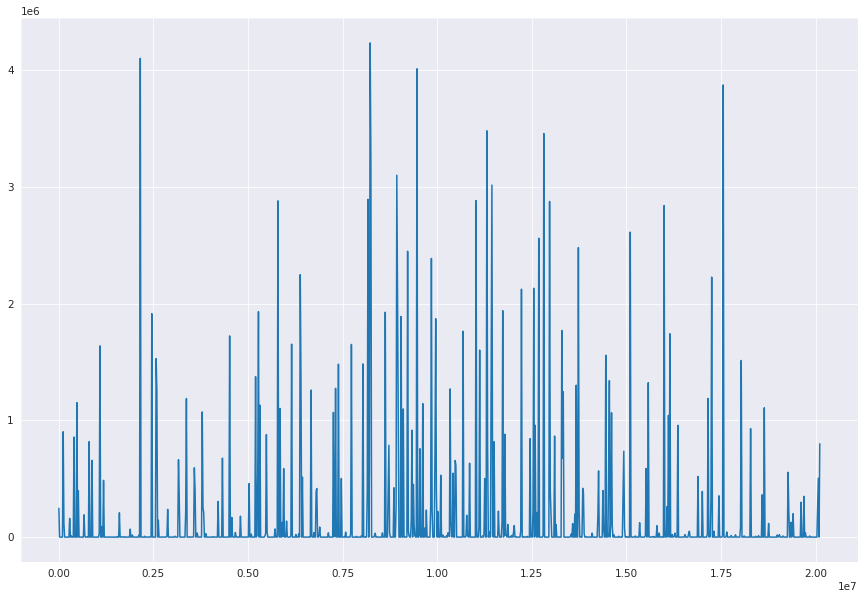

In [301]:
plt.plot(df_chi_min['chi2'])